In [1]:
#attach your Google drive to read write file
#drive.mount('/content/drive')

In [2]:
## Importing the libraries:
#!pip install cachetools
import os, sys
import cachetools.func


import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

#WHO Health Observatory API wrapper

Below is a python code that you can use to get health related data for any country in the world from World Health Organisation (WHO). To learn more about the description of the data available there check their [Global Health Observatory](https://www.who.int/data/gho) page. In particular, you can refer to the [indicators](https://www.who.int/data/gho/data/indicators) and [Data API](https://www.who.int/data/gho/info/gho-odata-api) pages.

In [3]:
def print_full(x):
    '''
    This is to print nicely DataFrame wide tables
    '''
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', -1)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

def agegrp_func(x):
    '''
    Function to format how age group is presented
    WHO uses AGE20-30, we want just 20-30
    '''
    if 'AGELT1' in x:
        y = '0-1'
    elif 'AGE85' in x:
        y = '85+'
    else:
        y=x.replace('AGE','')

    return y

def agegrp_mid(x):
    '''
    Function to calculate the mid age of an age group
    '''
    if 'AGELT1' in x:
        y = -3
    elif 'AGE85' in x:
        y = 87
    else:
        try:
            y=int(np.mean([int(i) for i in x.replace('AGE','').split('-')]))
        except:
            y = int(x.replace('AGE','').split('-')[0])
    return y  

class whoapi():
    '''
    This class defines methods to get data from World Health Organisation (WHO) API
    The different WHO health and related data is structured by country and indicator id (ids) 
    For example 
    Country = ETH
    indicatorid='LIFE_0000000029' 
    describes the probability of dying in age groups for Ethiopia
    Reference: for more information about available WHO data, refer
    https://www.who.int/data/gho  
    '''
    def __init__(self, dim='GHO',**kwargs):
    #
        self.url = f"http://apps.who.int/gho/athena/api/{dim}"
        self.verbose = kwargs.get('verbose',0)

    @staticmethod
    def age_sex_stem(df):    
        '''
        To nicely format AGE and SEX columns
        '''
        if 'AGEGROUP' in df.columns:
            df['MidAge'] = df['AGEGROUP'].map(agegrp_mid)
            df['AGEGROUP'] = df['AGEGROUP'].map(agegrp_func)       
            df = df.sort_values('MidAge').reset_index().drop(columns=['index'])

        if 'SEX' in df.columns:
            df['SEX'] = df['SEX'].map(lambda x:{'MLE':'Male',
                                                  'FMLE':'Female',
                                                  'BTSX':'Both'}.get(x,x))
        return df    

    def get_ids(self,s):
        df = self.dfid

        name = s
        if isinstance(s,str):
            name = [s]    

        dflist = [] 
        for d in name:
            dflist.append(df[df['id'].map(lambda x : d in x)])

        #try:
        df = pd.concat(dflist)
        #except:
        #  df = pd.DataFrame()

        return df

    def get_gho_data(self, id, fdict=None, url=None,verbose=None):
        '''
        given 
          id: indicator id, 
          fdict: dictionary of filters e.g {'COUNTRY':ETH,'YEAR':2016} ethiopian data from 2016
          url (optional)
          verbose: feedback level (0 -  less info to print; >=2 debug mode)
        get data from WHO server and return it as pandas DataFrame 
        '''
        #
        verbose = self.verbose if verbose is None else verbose
        #
        ids = id
        if isinstance(id,list):
            ids = ','.join(id)

        if url is None:
            url = f"{self.url}/{ids}.csv"

        if verbose>1:
            print('API url:',url)

        if not fdict is None:
            url += '?filter=' + ";".join([f"{k}:{v}" for k, v in fdict.items()])

        df = pd.read_csv(url)
        df = df.dropna(axis=1, how='all')
        try:
            df = df.drop(columns=['Comments'])
            df = df.drop(columns=['Comments'])
        except:
          #print('not dropping Comments')
          pass

        return df

    def country_data(self,ids,countries=['ETH'],year=2016):    
        '''
        This is a wrapper to 
          method: get_gho_data 
        This method allows one easily to pass multiple countries in a list
        '''
        if isinstance(countries,str):
            countries = [countries]

        dflist = []
        verbose=self.verbose
        for c in countries:
            print(f'processing country={c}')
            df = self.get_gho_data(ids,fdict={'COUNTRY':c,'YEAR':year},verbose=verbose)
            print(df.shape)
            verbose += 2
            dflist.append(df)

        df = pd.concat(dflist)
        print('all_df.shape',df.shape)
        return df

    def death_rates(self,**kwargs):
        '''
        This method fetchs data for the death rate from WHO server. 
        if a list of countries in their iso-3 code (e.g ITH, ETH, USA..) passed
        using keyword 
          countries=[ITH, ETH, USA], 
        The data will be returned only to these countries
        '''
        name = 'LIFE_0000000029'
        try:
            return self.age_sex_stem(self.country_data(name,**kwargs))
        except:
            return self.country_data(name,**kwargs)

    def dying_prob(self,**kwargs):
        '''
        This method fetchs the probability of dying data at a given age from WHO serer  
        if a list of countries in their iso-3 code (e.g ITH, ETH, USA..) passed
        using keyword 
          countries=[ITH, ETH, USA], 
        The data will be returned only to these countries
        '''

        name = 'LIFE_0000000030'
        df = self.country_data(name,**kwargs)
        try:
            return self.age_sex_stem(df)
        except:
            raise
        return df  
    def prop_dying_ncd_3070(self, **kwargs):
        name = 'NCDMORT3070'
        df = self.country_data(name, **kwargs)
        try:
            return self.age_sex_stem(df)
        except:
            return df

In [28]:
#initiate the whoapi class
hapi = whoapi()

#get data for dying probabilty of countries
df_pd = hapi.dying_prob(countries=["NGA","ETH","GHA"])

#plot data
print('dying prob df.shape',df_pd.shape)
xtickslabel = df_pd['AGEGROUP'].unique()
xticks = df_pd['MidAge'].unique()

processing country=NGA
(38, 9)
processing country=ETH
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000030.csv
(38, 9)
processing country=GHA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000030.csv
(38, 9)
all_df.shape (114, 9)
dying prob df.shape (114, 10)


In [29]:
df_pd.head()

,GHO,PUBLISHSTATE,YEAR,REGION,COUNTRY,AGEGROUP,SEX,Display Value,Numeric,MidAge
0,LIFE_0000000030,PUBLISHED,2016,AFR,NGA,0-1,Male,0.071,0.07128,-3
1,LIFE_0000000030,PUBLISHED,2016,AFR,ETH,0-1,Female,0.036,0.03593,-3
2,LIFE_0000000030,PUBLISHED,2016,AFR,ETH,0-1,Male,0.044,0.04435,-3
3,LIFE_0000000030,PUBLISHED,2016,AFR,GHA,0-1,Female,0.037,0.03741,-3
4,LIFE_0000000030,PUBLISHED,2016,AFR,NGA,0-1,Female,0.062,0.06243,-3


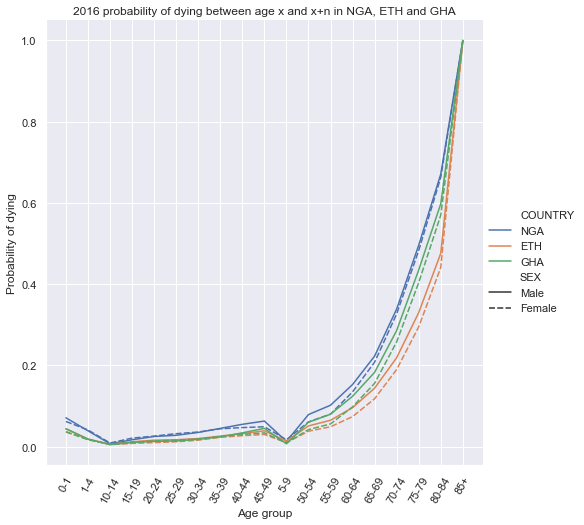

<Figure size 432x288 with 0 Axes>

In [32]:
sns.set_style("ticks", {"xtick.major": len(xticks)})
with sns.axes_style("darkgrid"):
    chart = sns.relplot(x='AGEGROUP', y='Display Value', hue='COUNTRY', data=df_pd, kind='line', style='SEX', height=7)
    chart.set(xlabel='Age group', ylabel='Probability of dying', title='2016 probability of dying between age x and x+n in NGA, ETH and GHA')
    plt.xticks(xtickslabel, rotation=60)
    plt.show()
    plt.savefig('dying prob.jpg')

## Challenge 2

Plot death rates as a function of age by calling the `death_rate` method. You can either use your choice of countries or use `countries=['ETH','ITA']`.

In [7]:
df_deaths = hapi.death_rates(countries=["GHA","NGA","ETH"])

processing country=GHA
(38, 9)
processing country=NGA
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000029.csv
(38, 9)
processing country=ETH
API url: http://apps.who.int/gho/athena/api/GHO/LIFE_0000000029.csv
(38, 9)
all_df.shape (114, 9)


In [34]:
df_deaths.head(10)

,GHO,PUBLISHSTATE,YEAR,REGION,COUNTRY,AGEGROUP,SEX,Display Value,Numeric,MidAge
0,LIFE_0000000029,PUBLISHED,2016,AFR,GHA,0-1,Male,0.046,0.04594,-3
1,LIFE_0000000029,PUBLISHED,2016,AFR,NGA,0-1,Female,0.066,0.06553,-3
2,LIFE_0000000029,PUBLISHED,2016,AFR,NGA,0-1,Male,0.075,0.07534,-3
3,LIFE_0000000029,PUBLISHED,2016,AFR,ETH,0-1,Female,0.037,0.03705,-3
4,LIFE_0000000029,PUBLISHED,2016,AFR,GHA,0-1,Female,0.039,0.03862,-3
5,LIFE_0000000029,PUBLISHED,2016,AFR,ETH,0-1,Male,0.046,0.04606,-3
6,LIFE_0000000029,PUBLISHED,2016,AFR,NGA,1-4,Male,0.010,0.01004,2
7,LIFE_0000000029,PUBLISHED,2016,AFR,ETH,1-4,Male,0.005,0.00465,2
8,LIFE_0000000029,PUBLISHED,2016,AFR,ETH,1-4,Female,0.004,0.00447,2
9,LIFE_0000000029,PUBLISHED,2016,AFR,GHA,1-4,Female,0.004,0.00442,2


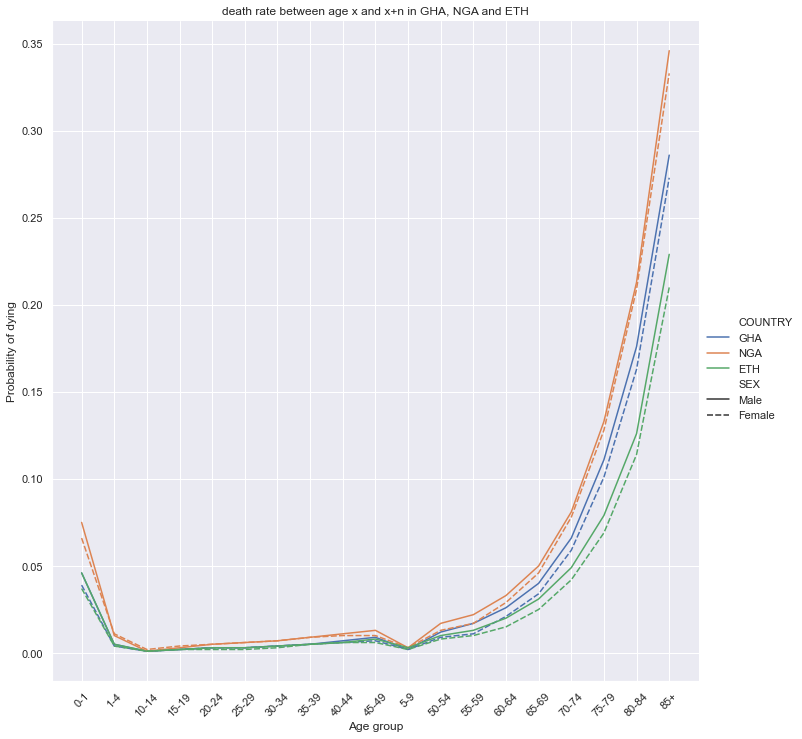

<Figure size 432x288 with 0 Axes>

In [8]:
sns.set_style("ticks", {"xtick.major": len(xticks)})
with sns.axes_style("darkgrid"):
    chart = sns.relplot(x='AGEGROUP', y='Display Value', hue='COUNTRY', data=df_deaths, kind='line', style='SEX', height= 10)
    chart.set(xlabel='Age group', ylabel='Probability of dying', title='death rate between age x and x+n in GHA, NGA and ETH')
    plt.xticks(xtickslabel, rotation=45)
    plt.show()
    plt.savefig('death rate.jpg')

### OBSERVATIONS
* Generally, death rate is higher at birth and reduces up to the age of 10-14 and then continues to increase.
* Males have a higher death rate compared to females.
* Of the 3 countries, Nigeria has the highest death rate, followed by Ghana and Ethiopia has the lowest rate.

## Challenge 3

Plot the probability (%) of dying between age 30 and exact age 70 from any of cardiovascular disease, cancer, diabetes, or chronic respiratory disease.

In [35]:
# To obtain the data, call the whoapi (prob_dying_ncd_3070)
df_pd_ncd = hapi.prop_dying_ncd_3070(countries=["ETH","NGA","GHA"])

print('dying prob df.shape',df_pd_ncd.shape)

processing country=ETH
(3, 8)
processing country=NGA
API url: http://apps.who.int/gho/athena/api/GHO/NCDMORT3070.csv
(3, 8)
processing country=GHA
API url: http://apps.who.int/gho/athena/api/GHO/NCDMORT3070.csv
(3, 8)
all_df.shape (9, 8)
dying prob df.shape (9, 8)


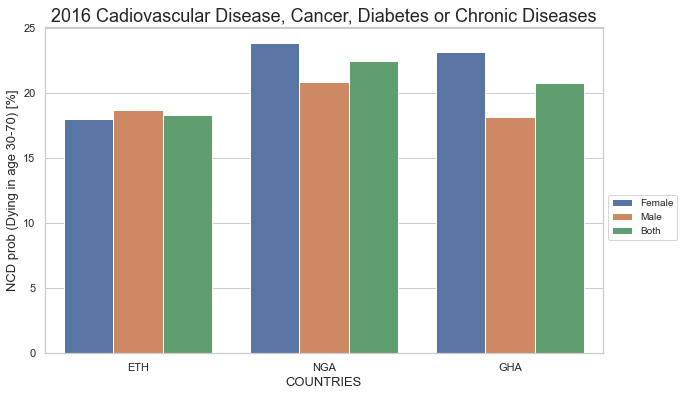

In [36]:
sns.set_style("ticks", {"xtick.major": len(xticks)})
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(10, 6))
    bar_chart = sns.barplot(x='COUNTRY', y='Display Value', hue='SEX', data=df_pd_ncd)
    bar_chart.legend(bbox_to_anchor=(1, 0.5),
          loc=2, fontsize=10);
    plt.title('2016 Cadiovascular Disease, Cancer, Diabetes or Chronic Diseases', size=18)
    plt.xlabel('COUNTRIES', fontsize=13)
    plt.ylabel('NCD prob (Dying in age 30-70) [%]', fontsize=13)
    plt.savefig('% prob. of dying (30-70).jpg')

### OBSERVATIONS
* Nigeria has the highest % probability of dying between age 30-70 due to the above mentioned diseases.
* In both Nigeria and Ghana, females have a higher probability of dying from these diseases compared to males. 
* However, the previous plot shows that males have a higher death rate to females, we can hypothesize that males death are not mainly caused by cardiovascular diseases, cancer, diabetes, or chronic respiratory disease but rather other factors play a major role.

# COVID19 Data Analysis 

Below is a python class that can be use to download latest COVID19 data from John Hopkins Server for any contry in the world.

In [37]:
#-----      
#-----
def fix_region_name(df, pairs = [["Mainland China", "China"]]):
    # fix region names
    for p in pairs:
        df['Country/Region'] = df['Country/Region'].str.replace(p[0],p[1])

    return df

    #-----
def merge_df_data(df1,df2):
    return pd.merge(df1, df2,how='left' ,on=['Province/State','Country/Region'])

    #-----
def str_add_func(*args):      
    out = []
    for x in args:
        if isinstance(x,str):
            out.append(x)

    return '_'.join(out)


class covid_data():
    '''
    Python class to obtain global COVID19 data from 
    John Hopkins GIT repository. This data is updated daily, 
    and the most upto date information available on the web.  
    '''
    def __init__(self,**kwargs):

        #
        nrow = kwargs.get('nrow',None)
        self.confirmed, self.dead, self.recovered = self.get_csseg_data(nrow=nrow)

    @staticmethod
    def create_ts(df):
        ts=df
        columns = ts['region']
        ts=ts.drop(['Province/State', 
                    'Country/Region',
                    'Lat', 
                    'Long',
                    'Population'], 
                   axis=1).set_index('region').T    

        ts.columns = columns 
        ts=ts.fillna(0)
        #
        ts.index.name = 'Date'
        return ts

    def search_agg(self, name,col='Country/Region',ts=True):

        if not isinstance(name,list):
            name = [name]

        out = {}
        for k,v in {'confirmed':self.confirmed,
                    'dead':self.dead,
                    'recovered':self.recovered}.items():
              #pd.columns(columns=)
            df_list= []     
            for n in name:
                df = v[v[col]==n].set_index(col).filter(regex='/20')
                df_list.append(df.sum(axis=0))

            df = pd.concat(df_list,axis=1, sort=False)
            df.columns = name
            out[k] = df

      # if ts:                
      #   out[k] = self.create_ts(df)
      # else:
      #   out[k] = df.T

        return out

    def search(self, name,col='Country/Region',ts=True):

        if not isinstance(name,list):
            name = [name]

        out = {}
        for k,v in {'confirmed':self.confirmed,
                    'dead':self.dead,
                    'recovered':self.recovered}.items():
            if ts:                
                out[k] = self.create_ts(v[v[col].map(lambda x: x in name)])
            else:
                out[k] = v[v[col] in name].T
        return out

    @cachetools.func.ttl_cache(maxsize=128, ttl=24 * 60)
    def get_csseg_data(self, nrow=None):

        url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master'
        path = f'{url}/csse_covid_19_data/csse_covid_19_time_series' 

        # 

        url = f'{path}/time_series_covid19_confirmed_global.csv'
        confirmed = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
        #
        url = f'{path}/time_series_covid19_deaths_global.csv'
        dead = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
        #
        url = f'{path}/time_series_covid19_recovered_global.csv'

        recovered = fix_region_name(pd.read_csv(url, nrows=nrow, error_bad_lines=False))
#         print(confirmed.head())
#         print(dead.head())

        #
        return confirmed, dead, recovered

## Challenge 4:
**Compare the number of COVID19 cases, deaths, and recoveries with respect to your neighbouring contries**

In [38]:
hopkins_api = covid_data()
hopkins_api.confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,39297,39341,39422,39486,39548,39616,39693,39703,39799,39870
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,14117,14266,14410,14568,14730,14899,15066,15231,15399,15570
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,51995,52136,52270,52399,52520,52658,52804,52940,53072,53325
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,2110,2110,2370,2370,2568,2568,2696,2696,2696,2995
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,5370,5402,5530,5725,5725,5958,6031,6246,6366,6488


In [39]:
countries = [ 'Nigeria', 'Benin', 'Ghana', 'Togo', 'Kenya']
d = hopkins_api.search_agg(countries)

In [40]:
cases = ['confirmed', 'dead', 'recovered']
for i, ctype in enumerate(cases):
    df = d[ctype].stack().reset_index()
    df = df.rename(columns={'level_0':'date','level_1':'country',0:ctype})     
    if i==0:
        df['date'] = pd.to_datetime(df['date'])
        dfall = df
    else:
        dfall[ctype] = df[ctype]
dfall.head()

,date,country,confirmed,dead,recovered
0,2020-01-22,Nigeria,0,0,0
1,2020-01-22,Benin,0,0,0
2,2020-01-22,Ghana,0,0,0
3,2020-01-22,Togo,0,0,0
4,2020-01-22,Kenya,0,0,0


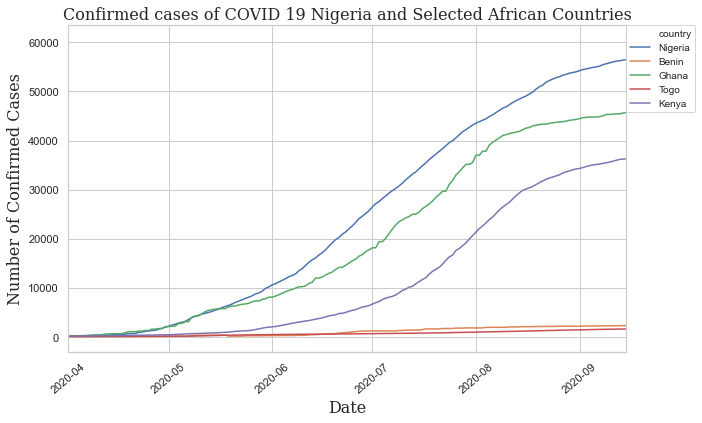

In [41]:
import datetime
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(10, 6))
    line = sns.lineplot(x='date', y='confirmed', hue='country', data=dfall, legend='full')
    line.legend(bbox_to_anchor=(1, 1), loc=2, fontsize=10, borderaxespad=0)
    plt.title('Confirmed cases of COVID 19 Nigeria and Selected African Countries', size=16, fontfamily='serif')
    plt.xlabel('Date', fontsize=16, fontfamily='serif')
    plt.ylabel('Number of Confirmed Cases', fontsize=16, fontfamily='serif')
    plt.xticks(rotation=40)
    plt.xlim([datetime.date(2020, 4, 1), datetime.date(2020, 9, 15)])
    plt.savefig('confirmed-cases.jpg')

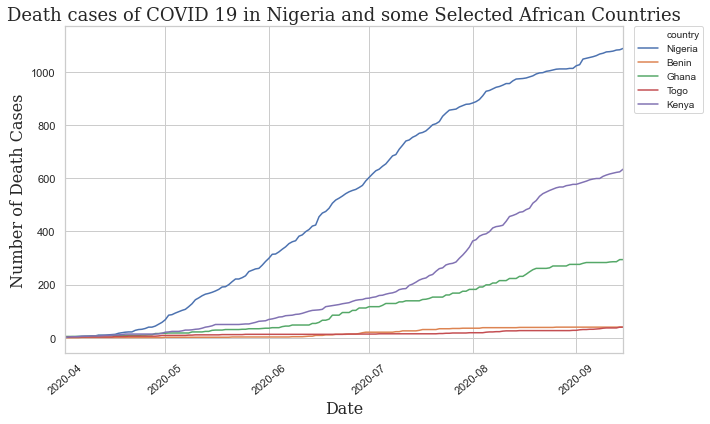

In [42]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(10, 6))
    line = sns.lineplot(x='date', y='dead', hue='country', data=dfall)
    line.legend(bbox_to_anchor=(1.02, 1), loc=2, fontsize=10, borderaxespad=0)
    plt.title('Death cases of COVID 19 in Nigeria and some Selected African Countries', size=18, fontfamily='serif')
    plt.xlabel('Date', fontsize=16, fontfamily='serif')
    plt.ylabel('Number of Death Cases', fontsize=16, fontfamily='serif')
    plt.xticks(rotation=40)
    plt.xlim([datetime.date(2020, 4, 1), datetime.date(2020, 9, 15)])
    plt.savefig('dead-cases.jpg')

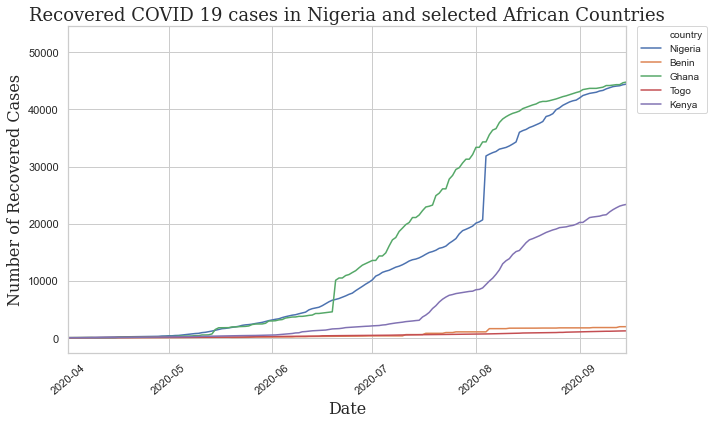

In [43]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(10, 6))
    line = sns.lineplot(x='date', y='recovered', hue='country', data=dfall)
    line.legend(bbox_to_anchor=(1.02, 1), loc=2, fontsize=10, borderaxespad=0)
    plt.title('Recovered COVID 19 cases in Nigeria and selected African Countries', size=18, fontfamily='serif')
    plt.xlabel('Date', fontsize=16, fontfamily='serif')
    plt.ylabel('Number of Recovered Cases', fontsize=16, fontfamily='serif')
    plt.xticks(rotation=40)
    plt.xlim([datetime.date(2020, 4, 1), datetime.date(2020, 9, 15)])
    plt.savefig('recovered-cases.jpg')

### OBSERVATIONS
* Number of confirmed cases of Covid-19 since April is increasing and Nigeria has the hifhest number among the 5 countries.
* Ghana has the highest number of recovered cases. 
* It appears that the number of recovered cases in Nigeria highly increased in early August.
* Benin and Togo has the lowest number of Covid-19 cases in all 5 countries.